In [1]:
# Characterize germline insertions

In [1]:
from collections import (
    defaultdict,
    namedtuple,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import seaborn as sns


PAIRS = {
    'H1': 'H3',
    'H4': 'H6',
    'H7': 'H9',
    'R1': 'R2',
    'R3': 'R4',
    'R5': 'R6',
    'R7': 'R8',
    'R9': 'R10',
    'R11': 'R12',
    'R13': 'R14',
    'R15': 'R16',
    'R17': 'R18',
    'R19': 'R20',
    'R21': 'R22',
    'R23': 'R24',
    'R25': 'R26',
    'R27': 'R28',
    'R29': 'R30',
    'R31': 'R32',
    'R33': 'R34',
    'R35': 'R36',
    'R37': 'R38',
    'R39': 'R40',
    'R41A': 'R42A',
    'R41B': 'R42B',
    'R43': 'R44',
    'R45': 'R46',
    'R47': 'R48',
    'R49': 'R50',
    'R51': 'R52',
    'R53': 'R54',
    'R55': 'R56',
    'R57': 'R58',
    'R59': 'R60',
    'R61': 'R62',
    'R63': 'R64',
}
PAIRS.update({v:k for k,v in PAIRS.items()})


COLUMNS = ['chrom', 'program', 'insertion', 'start', 'end', 'score', 'strand', 'idk', 'attributes']
insertion = namedtuple('Insertion', COLUMNS)

In [2]:
PUTATIVE_INSERTIONS = '../../pre-processed-data/raw_insertion_calls/all_putative_germline_insertions.gff3'
# PUTATIVE_INSERTIONS = '../../pre-processed-data/insertion_calls/coverage/combined_sorted_somatic_insertions.gff'
COVERAGE_FILE = '../../pre-processed-data/raw_insertion_calls/coverage_over_germline_insertions.tsv'
# COVERAGE_FILE = '../../pre-processed-data/insertion_calls/coverage/d'
ALL_INSERTIONS = '/Users/mvandenb/Downloads/Galaxy1199-[Concatenate_multiple_datasets_on_data_1198,_data_1197,_and_others].gff3'
# ALL_INSERTIONS = PUTATIVE_INSERTIONS
SOMATIC_DATA = ['../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_prosgfp_guts.gff', '../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_prosgfp_heads.gff']
INSERTION_SUMMARY = 'Pros all germline TSD insertions.tsv'
FINAL_TABLE = 'Pros Final germline table.tsv'

In [3]:
summary = namedtuple('summary', 'chrom start mate_support split_support nref vaf')


def read_insertions(path):
    all_inserts = defaultdict(list)
    with open(path) as in_fh:
        for line in in_fh:
            fields = line.split()
            chrom = fields[0]
            start = int(fields[3])
            attributes = dict(item.split("=") for item in fields[8].split(";"))
            mate_support = int(attributes['left_mate_count']) + int(attributes['right_mate_count'])
            total_support = int(attributes['total_left_count']) + int(attributes['total_right_count'])
            split_support = total_support - mate_support
            nref = int(attributes['nref'])
            vaf = total_support / (total_support + nref)
            all_inserts[attributes['ID']].append((summary(chrom, start, mate_support, split_support, nref, vaf)))
    return all_inserts

all_inserts = read_insertions(ALL_INSERTIONS)

In [4]:
def find_overlap_support(all_inserts, cluster_id, chrom, start):
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.mate_support, insert.split_support
    return 0, 0

def find_nref(all_inserts, cluster_id, chrom, start):
    # nref = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.nref
    return 0

def find_vaf(all_inserts, cluster_id, chrom, start):
    # vaf = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.vaf
    return 0

In [5]:
def summarize_overlaps(insertions):
    overlaps = set()
    cluster_ids = set()
    if not insertions:
        raise Exception('nope')
    for index, ins in enumerate(insertions):
        overlaps.add(ins.attributes['ID'].split('_')[0])
        cluster_ids.add(ins.attributes['ID'])
        for overlap in ins.attributes['overlaps'].split(','):
            if overlap:
                cluster_ids.add(overlap)
                overlaps.add(overlap.split('_')[0])
        is_somatic  = (ins.chrom, ins.start, ins.end, ins.insertion) in somatic
    return [index, ins.chrom, ins.start, ins.end, ins.insertion, ins.strand, is_somatic, len(overlaps), cluster_ids]


def get_insertions_by_coordinate(path):
    insertions_by_coordinate = defaultdict(list)
    with open(path) as fh:
        for line in fh:
            fields = line.strip().split('\t')
            fields[8] = dict(item.split("=") for item in fields[8].split(";"))
            ins = insertion(*fields)
            if ins.attributes['valid_TSD'] == 'True':
                insertions_by_coordinate[(ins.chrom, ins.start, ins.end, ins.insertion)].append(ins)
    return insertions_by_coordinate


insertions_by_coordinate = get_insertions_by_coordinate(PUTATIVE_INSERTIONS)


somatic = defaultdict(list)
for dataset in SOMATIC_DATA:
    somatic.update(get_insertions_by_coordinate(dataset))

somatic = {ins: summarize_overlaps(somatic[ins]) for ins in somatic}

In [6]:
len(insertions_by_coordinate)

3650

In [7]:
possible_somatic = {k:v for k, v in insertions_by_coordinate.items() if sum(1 for _ in v if _.attributes['overlaps'].count(',') == 0) == len(v)}

In [8]:
len(possible_somatic)

476

In [9]:
possible_private = defaultdict(list)

for insertions in insertions_by_coordinate.values():
    for record in insertions:
        overlaps = [overlap.split('_')[0] for overlap in record.attributes['overlaps'].split(',')]
        if len(overlaps) == 2 and PAIRS[overlaps[0]] == overlaps[1] and record.attributes['valid_TSD'] == 'True':
            possible_private[(record.chrom, record.start, record.end, record.insertion)].append(record)

In [10]:
early_somatic = {k:v for k,v in possible_private.items() if len(v) == 1}

In [11]:
private = {k:v for k,v in possible_private.items() if len(v) == 2}

In [12]:
def merge_connected_clusters(shared_summary):
    new_summary = []
    n_insertions = len(shared_summary)
    skip = -1
    for i, s in enumerate(shared_summary):
        if not skip == i:
            if i < (n_insertions - 1):
                n_s = shared_summary[i + 1]
                if s[-1] & n_s[-1]:
                    s[-1] = s[-1].union(n_s[-1])
                    skip = i + 1
            s[-2] = len(set(overlap.split('_')[0] for overlap in s[-1]))
            new_summary.append(s)
    return new_summary

<AxesSubplot:xlabel='Number of samples with insertion', ylabel='Number of insertion'>

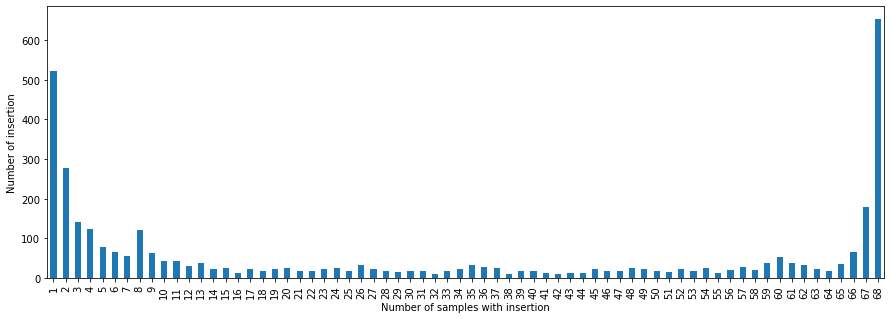

In [13]:
shared_germline = set(insertions_by_coordinate.keys()) - set(possible_somatic.keys()) - set(private.keys())
shared_summary = [summarize_overlaps(insertions_by_coordinate[ins]) for ins in insertions_by_coordinate]

# Make that a recursive call
new_summary = merge_connected_clusters(shared_summary)
new_summary = merge_connected_clusters(list(reversed(new_summary)))
new_summary = merge_connected_clusters(new_summary)
new_summary = list(reversed(merge_connected_clusters(list(reversed(new_summary)))))

shared_df = pd.DataFrame.from_records(shared_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps',]
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion")

<AxesSubplot:xlabel='Number of samples with insertion, merge aggressively', ylabel='Number of insertion'>

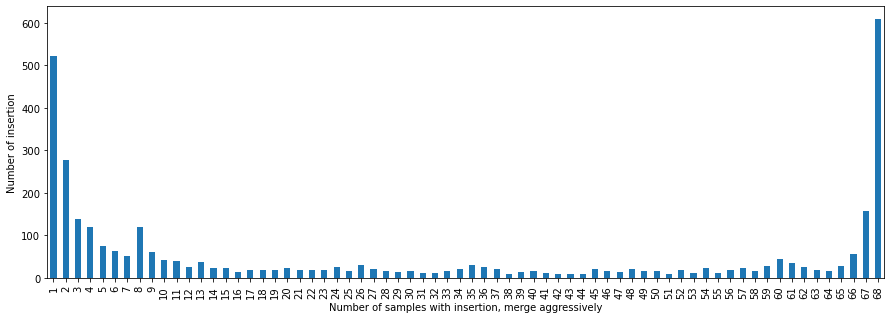

In [14]:
shared_df = pd.DataFrame.from_records(new_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps']
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
# shared_df = shared_df[shared_df.somatic == False]
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively")

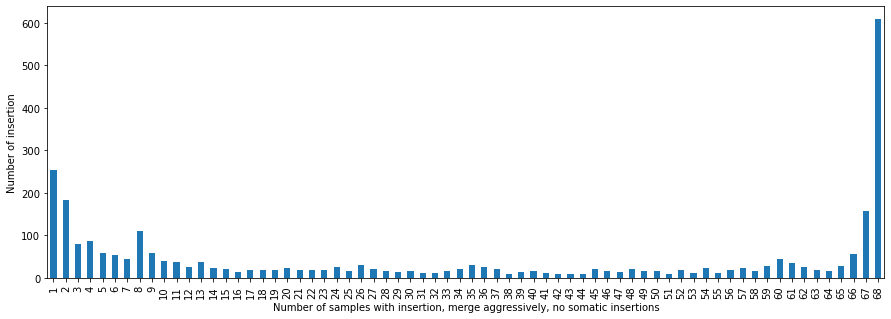

In [15]:
shared_df.somatic = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in somatic, axis=1)
shared_df['private'] = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in possible_private, axis=1)
shared_df.somatic.value_counts()
no_somatic = shared_df[shared_df.somatic == False]
if not no_somatic.empty:
    no_somatic.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively, no somatic insertions")

In [16]:
shared_df[(shared_df.somatic == False) & (shared_df.N_samples == 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
17,0,Y,3280194,3280204,Tabor,+,False,1,{H6_head_157},"[(18, 11)]",[65],[0.30851063829787234],False
36,0,Y,2925008,2925024,mdg1,+,False,1,{H4_gut_255},"[(7, 3)]",[16],[0.38461538461538464],False
42,0,Y,2742509,2742555,17.6,+,False,1,{H9_head_246},"[(2, 4)]",[28],[0.17647058823529413],False
45,0,Y,2488710,2488712,Quasimodo,+,False,1,{H7_gut_158},"[(45, 392)]",[250],[0.636098981077147],False
46,0,Y,2488690,2488712,3S18,+,False,1,{H1_gut_66},"[(40, 185)]",[184],[0.5501222493887531],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,0,2L,2621549,2621560,opus,+,False,1,{H1_gut_235},"[(13, 25)]",[5],[0.8837209302325582],False
3363,0,2L,2171902,2171906,copia,+,False,1,{R57_gut_100},"[(2, 4)]",[6],[0.5],False
3390,0,2L,833028,833039,BS,+,False,1,{H7_gut_1014},"[(24, 13)]",[37],[0.5],False
3391,0,2L,801430,801443,mdg1,+,False,1,{H9_head_267},"[(19, 11)]",[26],[0.5357142857142857],False


In [17]:
shared_df.strand.value_counts()

+    3402
Name: strand, dtype: int64

In [18]:
shared_df[(shared_df.somatic == False) & (shared_df.private == True)].insertion.value_counts()

hobo         34
roo          14
FB           10
copia         8
rover         6
BS            2
Tirant        2
Juan          1
I-element     1
INE-1         1
Rt1b          1
Doc           1
Stalker2      1
Tabor         1
pogo          1
flea          1
Quasimodo     1
Name: insertion, dtype: int64

In [19]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover')].N_samples.value_counts()

1     29
2     26
3     14
4     14
6      5
7      5
9      3
5      3
44     2
8      1
68     1
57     1
11     1
12     1
15     1
17     1
26     1
33     1
10     1
Name: N_samples, dtype: int64

In [20]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover') & (shared_df.N_samples == 68)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
2226,57,2R,14487743,14487748,rover,+,False,68,"{H3_head_149, R17_gut_17, R22_head_42, R8_head...","[(27, 40), (2, 6), (3, 23), (29, 57), (56, 85)...","[46, 4, 20, 55, 48, 32, 30, 24, 36, 70, 45, 12...","[0.5929203539823009, 0.6666666666666666, 0.565...",False


In [21]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3634227,3634257,gypsy,+,False,11,"{R13_gut_354, R45_gut_179, R7_gut_221, H3_head...","[(96, 15), (0, 0), (1, 0), (4, 3), (36, 7), (1...","[74, 0, 6, 0, 87, 27, 91, 11, 114, 0, 0, 61]","[0.6, 0, 0.14285714285714285, 1.0, 0.330769230...",False
1,2,Y,3625759,3625762,gtwin,+,False,8,"{R12_head_419, R46_head_253, R49_gut_190, R39_...","[(76, 35), (22, 16), (10, 3), (19, 13), (21, 3...","[0, 1, 0, 0, 3, 0, 1, 7, 1, 7]","[1.0, 0.9743589743589743, 1.0, 1.0, 0.94444444...",False
2,9,Y,3625759,3625762,HeT-A,+,False,13,"{R4_head_323, H3_head_350, R33_gut_289, R38_he...","[(59, 37), (26, 35), (12, 20), (29, 25), (46, ...","[3, 0, 7, 16, 2, 1, 2, 0, 16, 3, 2, 1, 3]","[0.9696969696969697, 1.0, 0.8205128205128205, ...",False
3,13,Y,3625759,3625762,Stalker3,+,False,16,"{R41B_gut_126, R37_gut_221, R25_gut_242, R41A_...","[(3, 1), (14, 13), (15, 29), (10, 8), (18, 17)...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 5, 2, 6, 2, 0, 2, 1]","[1.0, 1.0, 1.0, 0.9473684210526315, 1.0, 1.0, ...",False
4,10,Y,3625759,3625762,Stalker2,+,False,23,"{R61_gut_306, R45_gut_173, R53_gut_220, R30_he...","[(24, 9), (13, 12), (0, 0), (5, 19), (5, 12), ...","[3, 0, 0, 1, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 1, ...","[0.9166666666666666, 1.0, 0, 0.96, 1.0, 1.0, 1...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,0,2L,223133,223138,rover,+,True,11,"{R13_gut_66, H4_gut_87, R11_gut_238, H7_gut_30...","[(3, 3), (2, 0), (1, 0), (3, 3), (1, 0), (0, 0...","[156, 63, 154, 102, 110, 0, 151, 104, 92, 38, ...","[0.037037037037037035, 0.03076923076923077, 0....",False
3398,1,2L,171710,171713,springer,+,False,3,"{R1_gut_105, H9_head_74, H7_gut_238}","[(6, 0), (44, 26), (19, 26)]","[102, 37, 16]","[0.05555555555555555, 0.6542056074766355, 0.73...",False
3399,0,2L,140056,140060,opus,+,False,1,{R6_head_25},"[(139, 53)]",[73],[0.7245283018867924],False
3400,60,2L,140056,140060,roo,+,False,67,"{R3_gut_63, R7_gut_29, R10_head_16, H3_head_48...","[(223, 71), (38, 43), (125, 30), (30, 54), (93...","[87, 51, 52, 54, 57, 30, 162, 125, 26, 39, 18,...","[0.7716535433070866, 0.6136363636363636, 0.748...",False


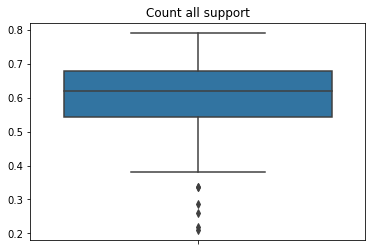

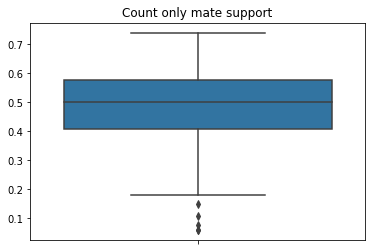

In [22]:
fully_penetrant = shared_df[shared_df.N_samples == 8]
x = fully_penetrant[['chrom', 'start', 'end', 'insertion']]
y = [insertions_by_coordinate[tuple(r)] for r in x.to_records(index=False)]

if not fully_penetrant.empty:
    # All support
    ratio = []
    x_insertions = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                if ins.chrom == 'X':
                    x_insertions.append(ins)
                    continue
                nref = int(ins.attributes['nref'])
                score = int(ins.score)
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count all support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))
    # Mate support
    ratio = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.chrom == 'X':
                continue
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                nref = int(ins.attributes['nref'])
                score = int(ins.attributes['left_mate_count']) + int(ins.attributes['right_mate_count'])
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count only mate support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))

In [23]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3634227,3634257,gypsy,+,False,11,"{R13_gut_354, R45_gut_179, R7_gut_221, H3_head...","[(96, 15), (0, 0), (1, 0), (4, 3), (36, 7), (1...","[74, 0, 6, 0, 87, 27, 91, 11, 114, 0, 0, 61]","[0.6, 0, 0.14285714285714285, 1.0, 0.330769230...",False
1,2,Y,3625759,3625762,gtwin,+,False,8,"{R12_head_419, R46_head_253, R49_gut_190, R39_...","[(76, 35), (22, 16), (10, 3), (19, 13), (21, 3...","[0, 1, 0, 0, 3, 0, 1, 7, 1, 7]","[1.0, 0.9743589743589743, 1.0, 1.0, 0.94444444...",False
2,9,Y,3625759,3625762,HeT-A,+,False,13,"{R4_head_323, H3_head_350, R33_gut_289, R38_he...","[(59, 37), (26, 35), (12, 20), (29, 25), (46, ...","[3, 0, 7, 16, 2, 1, 2, 0, 16, 3, 2, 1, 3]","[0.9696969696969697, 1.0, 0.8205128205128205, ...",False
3,13,Y,3625759,3625762,Stalker3,+,False,16,"{R41B_gut_126, R37_gut_221, R25_gut_242, R41A_...","[(3, 1), (14, 13), (15, 29), (10, 8), (18, 17)...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 5, 2, 6, 2, 0, 2, 1]","[1.0, 1.0, 1.0, 0.9473684210526315, 1.0, 1.0, ...",False
4,10,Y,3625759,3625762,Stalker2,+,False,23,"{R61_gut_306, R45_gut_173, R53_gut_220, R30_he...","[(24, 9), (13, 12), (0, 0), (5, 19), (5, 12), ...","[3, 0, 0, 1, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 1, ...","[0.9166666666666666, 1.0, 0, 0.96, 1.0, 1.0, 1...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,0,2L,223133,223138,rover,+,True,11,"{R13_gut_66, H4_gut_87, R11_gut_238, H7_gut_30...","[(3, 3), (2, 0), (1, 0), (3, 3), (1, 0), (0, 0...","[156, 63, 154, 102, 110, 0, 151, 104, 92, 38, ...","[0.037037037037037035, 0.03076923076923077, 0....",False
3398,1,2L,171710,171713,springer,+,False,3,"{R1_gut_105, H9_head_74, H7_gut_238}","[(6, 0), (44, 26), (19, 26)]","[102, 37, 16]","[0.05555555555555555, 0.6542056074766355, 0.73...",False
3399,0,2L,140056,140060,opus,+,False,1,{R6_head_25},"[(139, 53)]",[73],[0.7245283018867924],False
3400,60,2L,140056,140060,roo,+,False,67,"{R3_gut_63, R7_gut_29, R10_head_16, H3_head_48...","[(223, 71), (38, 43), (125, 30), (30, 54), (93...","[87, 51, 52, 54, 57, 30, 162, 125, 26, 39, 18,...","[0.7716535433070866, 0.6136363636363636, 0.748...",False


In [24]:
shared_df.somatic.value_counts()

False    2901
True      501
Name: somatic, dtype: int64

In [25]:
shared_df.N_samples.value_counts()

68    608
1     522
2     277
67    158
3     138
     ... 
43     10
42     10
51     10
38      9
44      9
Name: N_samples, Length: 68, dtype: int64

In [26]:
shared_df[(shared_df.somatic == True) & (shared_df.N_samples > 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
130,0,X,22835722,22835727,copia,+,True,2,"{R49_gut_198, R57_gut_447}","[(1, 0), (9, 4)]","[16, 9]","[0.058823529411764705, 0.5909090909090909]",False
180,0,X,21243320,21243325,rover,+,True,5,"{R57_gut_86, H4_gut_69, R61_gut_127, R43_gut_5...","[(4, 0), (0, 1), (1, 0), (0, 5), (10, 6)]","[43, 53, 13, 16, 7]","[0.0851063829787234, 0.018518518518518517, 0.0...",False
209,0,X,19568808,19568812,rover,+,True,2,"{R61_gut_319, R39_gut_46, R39_gut_45}","[(21, 11), (0, 1), (0, 0)]","[3, 75, 0]","[0.9142857142857143, 0.013157894736842105, 0]",False
216,0,X,19335823,19335826,rover,+,True,3,"{R57_gut_116, R55_gut_26, R13_gut_63}","[(0, 1), (0, 0), (4, 9)]","[11, 0, 15]","[0.08333333333333333, 0, 0.4642857142857143]",False
257,0,X,18294955,18294960,rover,+,True,5,"{R11_gut_161, R41A_gut_22, H7_gut_200, R51_gut...","[(0, 0), (2, 0), (0, 1), (0, 0), (1, 0), (10, 8)]","[0, 16, 32, 0, 62, 1]","[0, 0.1111111111111111, 0.030303030303030304, ...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,0,2L,4152413,4152418,rover,+,True,3,"{R27_gut_29, R13_gut_38, R57_gut_83}","[(6, 16), (0, 2), (1, 0)]","[18, 82, 25]","[0.55, 0.023809523809523808, 0.038461538461538...",False
3378,0,2L,1446792,1446799,rover,+,True,7,"{R57_gut_233, R13_gut_105, R33_gut_135, R63_gu...","[(0, 0), (2, 0), (1, 0), (2, 0), (1, 0), (0, 1...","[0, 195, 112, 39, 45, 83, 68, 56]","[0, 0.01015228426395939, 0.008849557522123894,...",False
3386,0,2L,1053755,1053758,rover,+,True,3,"{R5_gut_9, R33_gut_15, R45_gut_3}","[(1, 0), (13, 13), (0, 1)]","[61, 64, 59]","[0.016129032258064516, 0.28888888888888886, 0....",False
3396,0,2L,482108,482112,rover,+,True,4,"{R63_gut_102, R39_gut_65, R39_gut_66, H4_gut_1...","[(1, 0), (1, 0), (1, 0), (28, 10), (1, 0)]","[29, 105, 43, 24, 60]","[0.03333333333333333, 0.009433962264150943, 0....",False


In [27]:
pretty_summary = shared_df[['chrom', 'start', 'end', 'insertion', 'somatic', 'private', 'N_samples', 'overlaps']]

In [28]:
pretty_summary.to_csv(INSERTION_SUMMARY, sep='\t', index=None)

In [29]:
pretty_summary

,chrom,start,end,insertion,somatic,private,N_samples,overlaps
0,Y,3634227,3634257,gypsy,False,False,11,"{R13_gut_354, R45_gut_179, R7_gut_221, H3_head..."
1,Y,3625759,3625762,gtwin,False,False,8,"{R12_head_419, R46_head_253, R49_gut_190, R39_..."
2,Y,3625759,3625762,HeT-A,False,False,13,"{R4_head_323, H3_head_350, R33_gut_289, R38_he..."
3,Y,3625759,3625762,Stalker3,False,False,16,"{R41B_gut_126, R37_gut_221, R25_gut_242, R41A_..."
4,Y,3625759,3625762,Stalker2,False,False,23,"{R61_gut_306, R45_gut_173, R53_gut_220, R30_he..."
...,...,...,...,...,...,...,...,...
3397,2L,223133,223138,rover,True,False,11,"{R13_gut_66, H4_gut_87, R11_gut_238, H7_gut_30..."
3398,2L,171710,171713,springer,False,False,3,"{R1_gut_105, H9_head_74, H7_gut_238}"
3399,2L,140056,140060,opus,False,False,1,{R6_head_25}
3400,2L,140056,140060,roo,False,False,67,"{R3_gut_63, R7_gut_29, R10_head_16, H3_head_48..."


In [30]:
coverage = pd.read_csv(COVERAGE_FILE, sep='\t')

final_table = pd.concat([shared_df, coverage], axis=1)
final_table['median_coverage'] = final_table.iloc[:, 10:].median(axis=1)


def high_and_low_support(list_of_tuples):
    support_one = sum(list_of_tuples[0])
    if len(list_of_tuples) == 1:
        return False
    support_two = sum(list_of_tuples[1])
    if min(support_one, support_two) < 3 and max(support_one, support_two) > 10:
        return True
    return False


final_table['early_developmental'] = (final_table['somatic'] == False) & (final_table['private'] == True) & (final_table['support'].apply(high_and_low_support))

In [31]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
0,0,Y,3634227,3634257,gypsy,+,False,11,"{R13_gut_354, R45_gut_179, R7_gut_221, H3_head...","[(96, 15), (0, 0), (1, 0), (4, 3), (36, 7), (1...",...,2,0,0,0,0,8,10,10,0.0,False
1,2,Y,3625759,3625762,gtwin,+,False,8,"{R12_head_419, R46_head_253, R49_gut_190, R39_...","[(76, 35), (22, 16), (10, 3), (19, 13), (21, 3...",...,41,41,58,40,81,49,41,41,58.0,False
2,9,Y,3625759,3625762,HeT-A,+,False,13,"{R4_head_323, H3_head_350, R33_gut_289, R38_he...","[(59, 37), (26, 35), (12, 20), (29, 25), (46, ...",...,41,41,58,40,81,49,41,41,58.0,False
3,13,Y,3625759,3625762,Stalker3,+,False,16,"{R41B_gut_126, R37_gut_221, R25_gut_242, R41A_...","[(3, 1), (14, 13), (15, 29), (10, 8), (18, 17)...",...,0,0,0,42,0,0,64,64,0.0,False
4,10,Y,3625759,3625762,Stalker2,+,False,23,"{R61_gut_306, R45_gut_173, R53_gut_220, R30_he...","[(24, 9), (13, 12), (0, 0), (5, 19), (5, 12), ...",...,0,0,0,0,0,0,0,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,0,2L,223133,223138,rover,+,True,11,"{R13_gut_66, H4_gut_87, R11_gut_238, H7_gut_30...","[(3, 3), (2, 0), (1, 0), (3, 3), (1, 0), (0, 0...",...,27,27,22,30,25,26,26,26,25.0,False
3398,1,2L,171710,171713,springer,+,False,3,"{R1_gut_105, H9_head_74, H7_gut_238}","[(6, 0), (44, 26), (19, 26)]",...,27,27,22,30,25,26,26,26,25.0,False
3399,0,2L,140056,140060,opus,+,False,1,{R6_head_25},"[(139, 53)]",...,27,27,22,30,25,26,26,26,25.0,False
3400,60,2L,140056,140060,roo,+,False,67,"{R3_gut_63, R7_gut_29, R10_head_16, H3_head_48...","[(223, 71), (38, 43), (125, 30), (30, 54), (93...",...,27,27,22,30,25,26,26,26,25.0,False


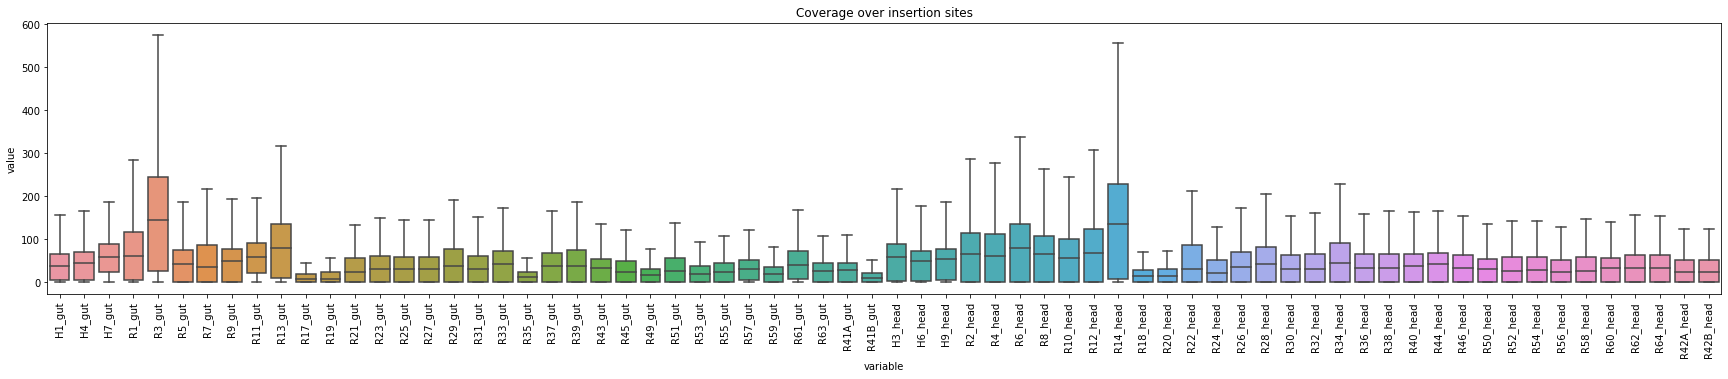

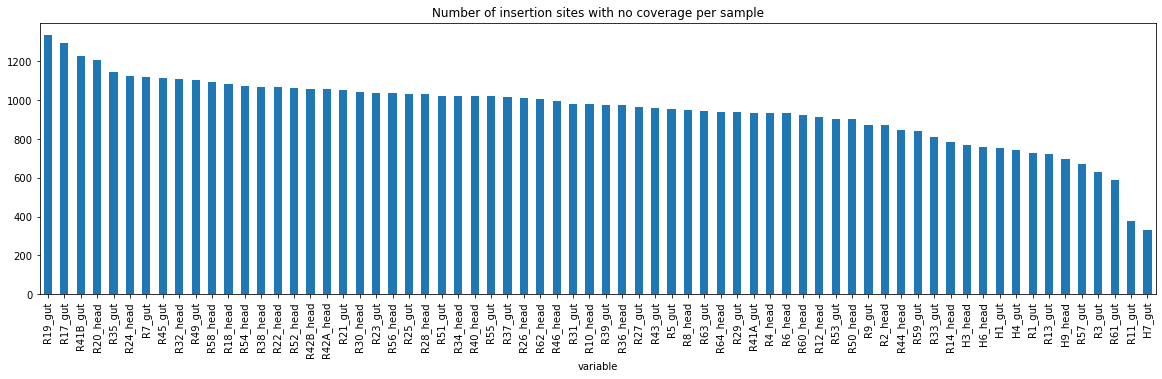

In [32]:
def plot_coverage_data(coverage_data):
    # Coverage over insertion sites
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.boxplot(x='variable', y='value', showfliers = False, data=coverage_data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title('Coverage over insertion sites')
    
    # Insertion sites without coverage
    fig, ax = plt.subplots(figsize=(30, 5))
    germline_sites_without_coverage = coverage_data['value'].eq(0).astype(int).groupby(coverage_data['variable']).sum().sort_values(ascending=False)
    germline_sites_without_coverage.plot(kind='bar', x='sample', y='count', figsize=(20, 5), title='Number of insertion sites with no coverage per sample', ax=ax)

coverage_data = final_table.iloc[:, 13:-2].melt()
plot_coverage_data(coverage_data)

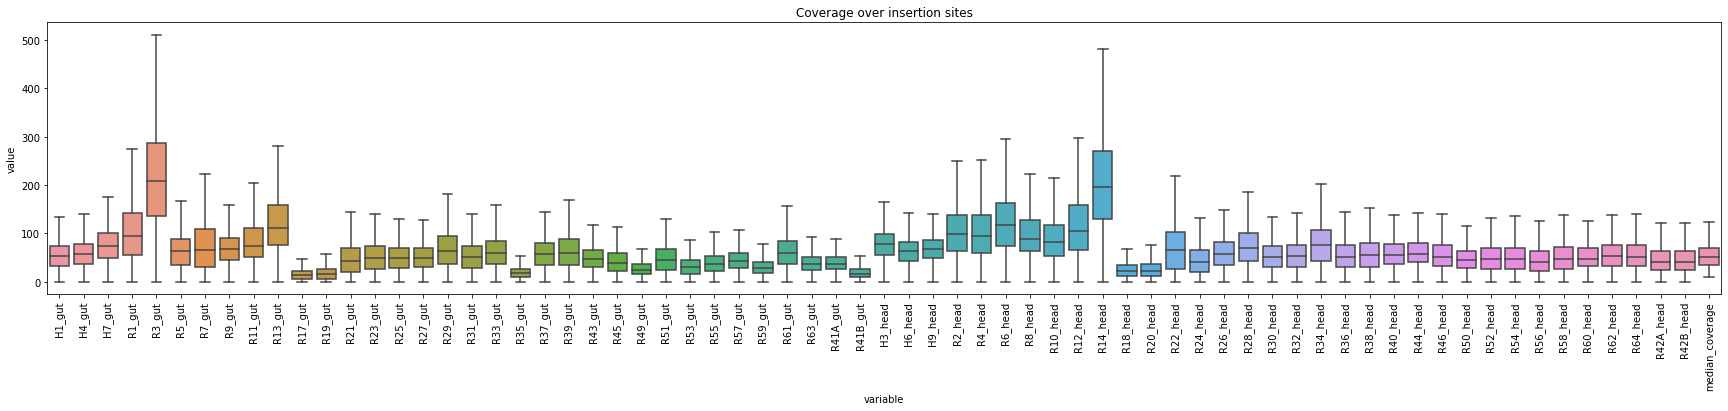

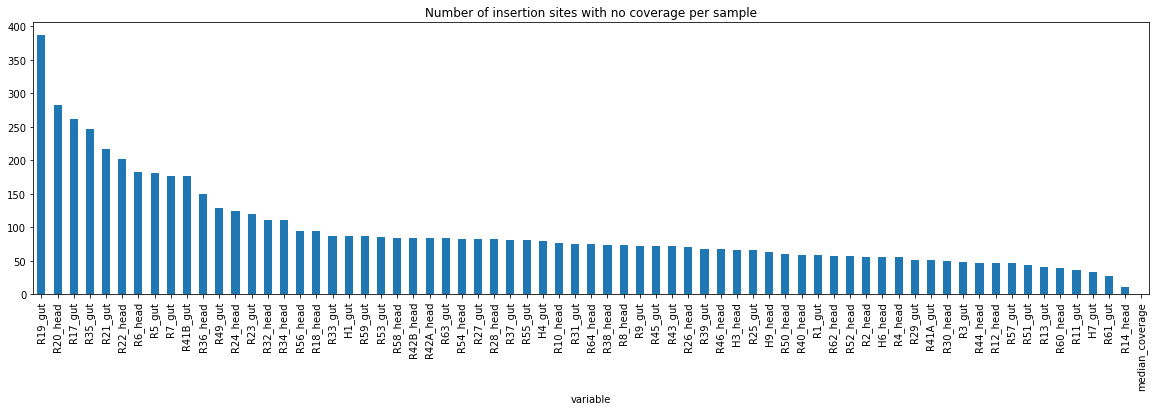

In [33]:
coverage_data = final_table[final_table.median_coverage >= 10].iloc[:, 13:-1].melt()
plot_coverage_data(coverage_data)

In [34]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
0,0,Y,3634227,3634257,gypsy,+,False,11,"{R13_gut_354, R45_gut_179, R7_gut_221, H3_head...","[(96, 15), (0, 0), (1, 0), (4, 3), (36, 7), (1...",...,2,0,0,0,0,8,10,10,0.0,False
1,2,Y,3625759,3625762,gtwin,+,False,8,"{R12_head_419, R46_head_253, R49_gut_190, R39_...","[(76, 35), (22, 16), (10, 3), (19, 13), (21, 3...",...,41,41,58,40,81,49,41,41,58.0,False
2,9,Y,3625759,3625762,HeT-A,+,False,13,"{R4_head_323, H3_head_350, R33_gut_289, R38_he...","[(59, 37), (26, 35), (12, 20), (29, 25), (46, ...",...,41,41,58,40,81,49,41,41,58.0,False
3,13,Y,3625759,3625762,Stalker3,+,False,16,"{R41B_gut_126, R37_gut_221, R25_gut_242, R41A_...","[(3, 1), (14, 13), (15, 29), (10, 8), (18, 17)...",...,0,0,0,42,0,0,64,64,0.0,False
4,10,Y,3625759,3625762,Stalker2,+,False,23,"{R61_gut_306, R45_gut_173, R53_gut_220, R30_he...","[(24, 9), (13, 12), (0, 0), (5, 19), (5, 12), ...",...,0,0,0,0,0,0,0,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,0,2L,223133,223138,rover,+,True,11,"{R13_gut_66, H4_gut_87, R11_gut_238, H7_gut_30...","[(3, 3), (2, 0), (1, 0), (3, 3), (1, 0), (0, 0...",...,27,27,22,30,25,26,26,26,25.0,False
3398,1,2L,171710,171713,springer,+,False,3,"{R1_gut_105, H9_head_74, H7_gut_238}","[(6, 0), (44, 26), (19, 26)]",...,27,27,22,30,25,26,26,26,25.0,False
3399,0,2L,140056,140060,opus,+,False,1,{R6_head_25},"[(139, 53)]",...,27,27,22,30,25,26,26,26,25.0,False
3400,60,2L,140056,140060,roo,+,False,67,"{R3_gut_63, R7_gut_29, R10_head_16, H3_head_48...","[(223, 71), (38, 43), (125, 30), (30, 54), (93...",...,27,27,22,30,25,26,26,26,25.0,False


In [35]:

final_table[final_table['early_developmental']]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
290,0,X,16483996,16484001,rover,+,False,2,"{H7_gut_285, H9_head_86}","[(11, 18), (0, 1)]",...,60,71,102,47,58,52,63,63,63.0,True
441,0,X,10217600,10217605,rover,+,False,2,"{R11_gut_100, R12_head_20}","[(30, 18), (0, 1)]",...,30,34,8,19,33,36,24,24,36.0,True
592,0,X,3641879,3641883,rover,+,False,2,"{H7_gut_325, H9_head_172}","[(4, 18), (0, 0)]",...,77,2,2,77,106,4,2,2,42.0,True
814,0,3R,29771322,29771324,copia,+,False,2,"{R12_head_119, R11_gut_796}","[(2, 0), (58, 76)]",...,99,50,82,46,87,118,64,64,85.0,True
1494,0,3L,22463004,22463009,copia,+,False,2,"{H9_head_164, H7_gut_590}","[(1, 0), (13, 26)]",...,75,51,67,39,73,65,57,57,67.0,True
1731,0,3L,12102764,12102769,copia,+,False,2,"{R12_head_14, R11_gut_103}","[(0, 0), (48, 10)]",...,34,53,42,36,57,48,57,57,49.0,True
1823,0,3L,8940174,8940178,rover,+,False,2,"{H9_head_354, H7_gut_1269}","[(0, 1), (18, 13)]",...,39,57,46,22,37,39,47,47,47.0,True
2017,0,2R,24967854,24967858,rover,+,False,2,"{H9_head_347, H7_gut_1055}","[(0, 1), (4, 12)]",...,59,59,103,45,51,34,62,62,59.0,True
2470,0,2R,6119866,6119870,copia,+,False,2,"{H7_gut_166, H9_head_35}","[(15, 17), (0, 1)]",...,71,73,85,69,96,83,65,65,80.0,True
2942,0,2L,19341866,19341870,copia,+,False,2,"{H7_gut_447, H9_head_125}","[(20, 32), (0, 0)]",...,0,0,0,0,0,0,0,0,0.0,True


Text(0.5, 1.0, 'Germline private TE insertions')

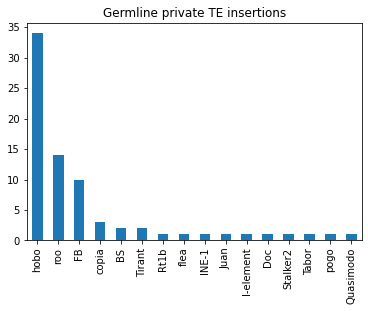

In [36]:
final_table[(~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

Text(0.5, 1.0, 'Germline private TE insertions')

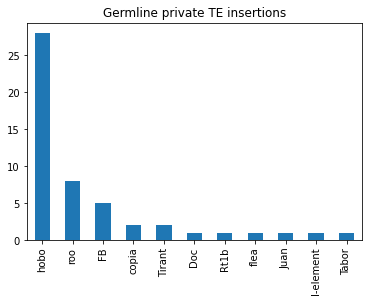

In [37]:
final_table[(final_table['median_coverage'] >=10) & (~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

In [38]:
final_table[(~final_table['early_developmental']) & (final_table['private']) & (final_table['insertion'] == 'copia')]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
335,0,X,14390484,14390489,copia,+,False,2,"{R7_gut_32, R8_head_30}","[(44, 19), (45, 16)]",...,70,43,72,54,85,50,53,53,68.0,False
3223,0,2L,9437844,9437848,copia,+,False,2,"{R11_gut_424, R12_head_55}","[(69, 33), (9, 0)]",...,0,0,0,0,1,0,0,0,0.0,False
3401,1,2L,62011,62015,copia,+,False,2,"{H7_gut_87, H9_head_34}","[(45, 35), (36, 39)]",...,73,38,55,36,39,39,49,49,36.0,False


In [39]:
final_table[final_table['median_coverage'] < 10]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
0,0,Y,3634227,3634257,gypsy,+,False,11,"{R13_gut_354, R45_gut_179, R7_gut_221, H3_head...","[(96, 15), (0, 0), (1, 0), (4, 3), (36, 7), (1...",...,2,0,0,0,0,8,10,10,0.0,False
3,13,Y,3625759,3625762,Stalker3,+,False,16,"{R41B_gut_126, R37_gut_221, R25_gut_242, R41A_...","[(3, 1), (14, 13), (15, 29), (10, 8), (18, 17)...",...,0,0,0,42,0,0,64,64,0.0,False
4,10,Y,3625759,3625762,Stalker2,+,False,23,"{R61_gut_306, R45_gut_173, R53_gut_220, R30_he...","[(24, 9), (13, 12), (0, 0), (5, 19), (5, 12), ...",...,0,0,0,0,0,0,0,0,0.0,False
5,1,Y,3619774,3619779,Stalker3,+,False,2,"{R24_head_226, H9_head_317}","[(3, 6), (33, 19)]",...,0,0,0,0,1,0,0,0,0.0,False
8,3,Y,3601883,3601887,roo,+,False,7,"{R21_gut_241, R22_head_262, R36_head_228, R35_...","[(15, 42), (17, 47), (101, 42), (0, 0), (1, 7)...",...,0,0,0,0,0,0,0,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,1,2L,1067214,1067222,FB,+,False,2,"{R60_head_6, R59_gut_37}","[(41, 10), (18, 5)]",...,3,5,3,22,5,18,0,0,9.0,False
3388,3,2L,949795,949803,roo,+,False,8,"{R52_head_73, R36_head_106, R51_gut_85, R41A_g...","[(41, 22), (3, 1), (40, 33), (1, 0), (0, 1), (...",...,0,0,0,56,0,12,0,0,4.0,False
3390,0,2L,833028,833039,BS,+,False,1,{H7_gut_1014},"[(24, 13)]",...,10,14,3,5,5,6,2,2,6.0,False
3395,65,2L,512702,512706,mdg3,+,False,68,"{R38_head_32, R22_head_38, R25_gut_37, R42A_he...","[(50, 47), (13, 50), (19, 27), (26, 31), (54, ...",...,7,4,7,3,12,11,2,2,7.0,False


In [40]:
final_table.to_csv(FINAL_TABLE, sep='\t', index=None)

In [41]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
0,0,Y,3634227,3634257,gypsy,+,False,11,"{R13_gut_354, R45_gut_179, R7_gut_221, H3_head...","[(96, 15), (0, 0), (1, 0), (4, 3), (36, 7), (1...",...,2,0,0,0,0,8,10,10,0.0,False
1,2,Y,3625759,3625762,gtwin,+,False,8,"{R12_head_419, R46_head_253, R49_gut_190, R39_...","[(76, 35), (22, 16), (10, 3), (19, 13), (21, 3...",...,41,41,58,40,81,49,41,41,58.0,False
2,9,Y,3625759,3625762,HeT-A,+,False,13,"{R4_head_323, H3_head_350, R33_gut_289, R38_he...","[(59, 37), (26, 35), (12, 20), (29, 25), (46, ...",...,41,41,58,40,81,49,41,41,58.0,False
3,13,Y,3625759,3625762,Stalker3,+,False,16,"{R41B_gut_126, R37_gut_221, R25_gut_242, R41A_...","[(3, 1), (14, 13), (15, 29), (10, 8), (18, 17)...",...,0,0,0,42,0,0,64,64,0.0,False
4,10,Y,3625759,3625762,Stalker2,+,False,23,"{R61_gut_306, R45_gut_173, R53_gut_220, R30_he...","[(24, 9), (13, 12), (0, 0), (5, 19), (5, 12), ...",...,0,0,0,0,0,0,0,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,0,2L,223133,223138,rover,+,True,11,"{R13_gut_66, H4_gut_87, R11_gut_238, H7_gut_30...","[(3, 3), (2, 0), (1, 0), (3, 3), (1, 0), (0, 0...",...,27,27,22,30,25,26,26,26,25.0,False
3398,1,2L,171710,171713,springer,+,False,3,"{R1_gut_105, H9_head_74, H7_gut_238}","[(6, 0), (44, 26), (19, 26)]",...,27,27,22,30,25,26,26,26,25.0,False
3399,0,2L,140056,140060,opus,+,False,1,{R6_head_25},"[(139, 53)]",...,27,27,22,30,25,26,26,26,25.0,False
3400,60,2L,140056,140060,roo,+,False,67,"{R3_gut_63, R7_gut_29, R10_head_16, H3_head_48...","[(223, 71), (38, 43), (125, 30), (30, 54), (93...",...,27,27,22,30,25,26,26,26,25.0,False
